# Multilingual Name Classifier using RNN and LSTM

#### In the following code, I have developed a language classification model using Recurrent Neural Network (RNN) and Long Short Term Memory (LSTM) to predict the origin language of the input names. I have fine-tuned the hyperparameters to identify the most optimal model for this language classification task.

##### Import necessary libraries

In [1]:
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
from io import open
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

##### Lists all possible letters and the "End of String" marker. Loaded the data from the files and performed data pre-processing


In [2]:

# All letters and the "EOS" (End of String) marker
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


file_paths = [
    r'/content/drive/MyDrive/DSP Assignments/Arabic.txt',
    r'/content/drive/MyDrive/DSP Assignments/Chinese.txt',
    r'/content/drive/MyDrive/DSP Assignments/Czech.txt',
    r'/content/drive/MyDrive/DSP Assignments/English.txt',
    r'/content/drive/MyDrive/DSP Assignments/French.txt',
    r'/content/drive/MyDrive/DSP Assignments/German.txt',
    r'/content/drive/MyDrive/DSP Assignments/Greek.txt',
    r'/content/drive/MyDrive/DSP Assignments/Irish.txt',
    r'/content/drive/MyDrive/DSP Assignments/Italian.txt',
    r'/content/drive/MyDrive/DSP Assignments/Japanese.txt',
    r'/content/drive/MyDrive/DSP Assignments/Russian.txt',
    r'/content/drive/MyDrive/DSP Assignments/Spanish.txt',
]

# Utility function to turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Load data
category_lines = {}
all_categories = []

for file_path in file_paths:
    # Extract category (language) from the file name
    category = os.path.splitext(os.path.basename(file_path))[0]
    all_categories.append(category)
    lines = open(file_path, encoding='utf-8').read().strip().split('\n')
    lines = [unicode_to_ascii(line) for line in lines]
    category_lines[category] = lines

# Print out some samples to check the data
for category in all_categories:
    print(category, ": ", category_lines[category][:5])

n_categories = len(all_categories) # Number of categories (languages)


Arabic :  ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Chinese :  ['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']
Czech :  ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
English :  ['Healy', 'Heath', 'Heathcote', 'Heather', 'Heatley']
French :  ['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']
German :  ['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']
Greek :  ['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']
Irish :  ['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis']
Italian :  ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
Japanese :  ['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']
Russian :  ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']
Spanish :  ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


##### Mounted the Google Drive to access the files in it.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### In the below code, I am preparing data for training and validation and also creating a custom dataset for organizing the data.

##### name_to_tensor: Converts names to tensors through one-hot encoding. Tensors have dimensions with max_length for name length, a batch size of 1, and n_letters as the character count.

##### category_to_tensor: Maps categories to Long tensors by their index in all_categories.

##### NamesDataset: A custom dataset class for data organization. It facilitates training and validation data management. The __getitem__ is used for accessing specific name-category pairs, transforming names with name_to_tensor and categories with category_to_tensor.

In [4]:
# Function to convert name and category to tensor
def name_to_tensor(name, max_length):
    tensor = torch.zeros(max_length, 1, n_letters)
    for li, letter in enumerate(name):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

def category_to_tensor(category):
    return torch.tensor([all_categories.index(category)], dtype=torch.long)

# Creating a custom dataset class for names
class NamesDataset(Dataset):
    def __init__(self, category_lines, all_categories, max_length):
        self.names = []
        self.categories = []
        self.max_length = max_length
        for category in all_categories:
            for name in category_lines[category]:
                self.names.append(name)
                self.categories.append(category)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        name = self.names[index]
        category = self.categories[index]
        name_tensor = name_to_tensor(name, self.max_length)
        category_tensor = category_to_tensor(category)
        return name_tensor, category_tensor

##### This code segment divides the dataset into training and validation sets for each category. DataLoaders are established for easy batching and shuffling during model training.

In [5]:
# Split data into training and validation sets
train_data = {}
val_data = {}
for category in all_categories:
    train, val = train_test_split(category_lines[category], test_size=0.2, random_state=42)
    train_data[category] = train
    val_data[category] = val

# Get the maximum name length for padding
max_length = max(len(name) for category in all_categories for name in category_lines[category])


# Create datasets and dataloaders
train_dataset = NamesDataset(train_data, all_categories, max_length)
val_dataset = NamesDataset(val_data, all_categories, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


##### Defining a function to create and train the RNN Model

In [6]:
# Updated RNN model with an additional RNN layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initializing hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through RNN layers
        out, _ = self.rnn(x, h0)

        # Taking the output from the last time step and pass it through the fully connected layer
        out = self.fc(out[:, -1, :])

        # Apply softmax to get probabilities
        out = self.softmax(out)
        return out

##### Defining a function to create and train the LSTM Model


In [7]:
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initializing hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM layers
        out, _ = self.lstm(x, (h0, c0))

        # Taking the output from the last time step and pass it through the fully connected layer
        out = self.fc(out[:, -1, :])

        # Apply softmax to get probabilities
        out = self.softmax(out)
        return out


##### Training and Evaluation of the RNN Model with Varying Epochs

Epoch 1, Training Loss: 2.4092709975005273
Epoch 1, Validation Loss: 2.2067409522898562
Best model saved with validation loss: 2.2067409522898562
Epoch 2, Training Loss: 2.1141173352752873
Epoch 2, Validation Loss: 2.0698635035806947
Best model saved with validation loss: 2.0698635035806947
Epoch 3, Training Loss: 1.960635768477194
Epoch 3, Validation Loss: 1.8106337674297728
Best model saved with validation loss: 1.8106337674297728
Epoch 4, Training Loss: 1.8391672883907595
Epoch 4, Validation Loss: 1.8476429262139775
Epoch 5, Training Loss: 1.7406049461790878
Epoch 5, Validation Loss: 1.8714523154336054
Epoch 6, Training Loss: 1.6956945961147412
Epoch 6, Validation Loss: 1.6036638369162877
Best model saved with validation loss: 1.6036638369162877
Epoch 7, Training Loss: 1.5927559852060689
Epoch 7, Validation Loss: 1.5507311996173214
Best model saved with validation loss: 1.5507311996173214
Epoch 8, Training Loss: 1.6344582783016144
Epoch 8, Validation Loss: 1.602320271133034
Epoch 9,

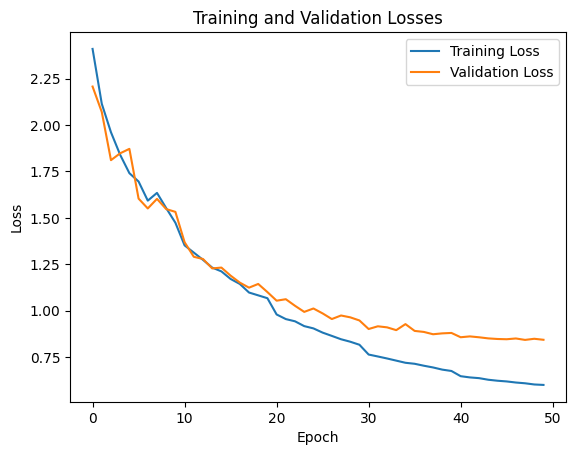

In [8]:
import matplotlib.pyplot as plt

# Hyperparameters
n_hidden = 128
n_categories = len(all_categories)
num_layers = 1
learning_rate = 0.001
num_epochs = 50

# Instantiate the model, loss function, and optimizer
model = RNN(n_letters, n_hidden, n_categories, num_layers)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduling
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Variables to keep track of losses for each epoch
training_losses = []
validation_losses = []

# Variable to keep track of the lowest validation loss
best_val_loss = float('inf')  # Initialize with infinity

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    for names, categories in train_dataloader:
        optimizer.zero_grad()
        outputs = model(names.squeeze(2))
        loss = criterion(outputs, categories.squeeze(1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = total_loss / len(train_dataloader)
    training_losses.append(train_loss)  # Store the training loss
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss}')

    # Validation loop to compute the validation loss
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for names, categories in val_dataloader:
            outputs = model(names.squeeze(2))
            loss = criterion(outputs, categories.squeeze(1))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)  # Store the validation loss
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Learning rate scheduling step
    scheduler.step()

    # Save the model if it has the lowest validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/DSP Assignments/best_model_rnn.pth')
        print(f"Best model saved with validation loss: {best_val_loss}")

# Plotting the training and validation losses
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


##### Training and Evaluation of the LSTM Model with Varying Epochs

Epoch 1, Training Loss: 2.2183951483323026
Epoch 1, Validation Loss: 1.9760991288265128
Best model saved with validation loss: 1.9760991288265128
Epoch 2, Training Loss: 1.8372774132236636
Epoch 2, Validation Loss: 1.6840819392252613
Best model saved with validation loss: 1.6840819392252613
Epoch 3, Training Loss: 1.6439362811556768
Epoch 3, Validation Loss: 1.5915077077308755
Best model saved with validation loss: 1.5915077077308755
Epoch 4, Training Loss: 1.5114751814177674
Epoch 4, Validation Loss: 1.4493497711111296
Best model saved with validation loss: 1.4493497711111296
Epoch 5, Training Loss: 1.3717666375556143
Epoch 5, Validation Loss: 1.3072026482036523
Best model saved with validation loss: 1.3072026482036523
Epoch 6, Training Loss: 1.2006840629342994
Epoch 6, Validation Loss: 1.1123454383498914
Best model saved with validation loss: 1.1123454383498914
Epoch 7, Training Loss: 1.0408309726423808
Epoch 7, Validation Loss: 1.0245954177703138
Best model saved with validation los

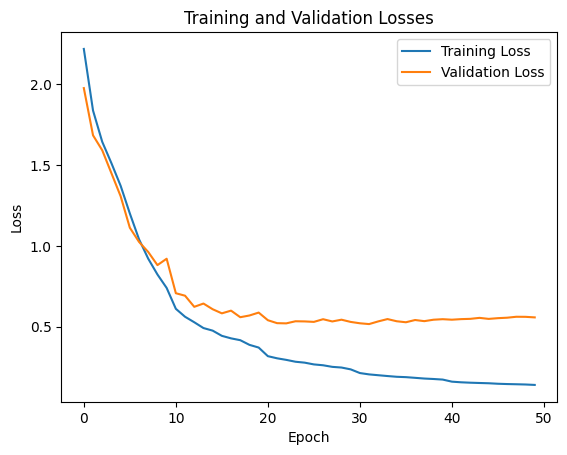

In [9]:
import matplotlib.pyplot as plt

# Instantiate the LSTM model
lstm_model = LSTMModel(n_letters, 128, n_categories, num_layers=1)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Adjust parameters as needed

# Variables to keep track of losses for each epoch
training_losses = []
validation_losses = []

# Variable to keep track of the lowest validation loss
best_val_loss = float('inf')  # Initialize with infinity

# Training loop for the LSTM model
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for names, categories in train_dataloader:
        optimizer.zero_grad()
        outputs = lstm_model(names.squeeze(2))
        loss = criterion(outputs, categories.squeeze(1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = total_loss / len(train_dataloader)
    training_losses.append(train_loss)  # Store the training loss
    print(f'Epoch {epoch+1}, Training Loss: {train_loss}')

    # Validation loop to compute the validation loss
    lstm_model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for names, categories in val_dataloader:
            outputs = lstm_model(names.squeeze(2))
            loss = criterion(outputs, categories.squeeze(1))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)  # Store the validation loss
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')

    # Save the model if it has the lowest validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(lstm_model.state_dict(), '/content/drive/MyDrive/DSP Assignments/best_model_lstm.pth')
        print(f"Best model saved with validation loss: {best_val_loss}")

    # Adjust the learning rate
    scheduler.step()

# Plotting the training and validation losses
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


##### Load the saved best RNN model and evaluate its performance on the validation set.

In [10]:
# Evaluation loop on the validation set
# Load the saved best model
best_model_rnn = RNN(n_letters, n_hidden, n_categories, num_layers)
best_model_rnn.load_state_dict(torch.load('/content/drive/MyDrive/DSP Assignments/best_model_rnn.pth'))
best_model_rnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for names, categories in val_dataloader:
        outputs = model(names.squeeze(2))
        _, predicted = torch.max(outputs, 1)
        total += categories.size(0)
        correct += (predicted == categories.squeeze(1)).sum().item()

        # Print predicted probabilities for each name
        probabilities = torch.exp(outputs)
        for i in range(len(names)):
            # Removing padded characters by stopping when a padding character is encountered
            original_name = ''.join([all_letters[torch.argmax(letter)] for letter in names[i] if torch.max(letter).item() > 0])
            print(f"Name: {original_name}, "
                  f"Predicted: {all_categories[predicted[i].item()]}, "
                  f"Probabilities: {probabilities[i].numpy()}")

print(f'Validation Accuracy: {100 * correct / total}%')


Streaming output truncated to the last 5000 lines.
 9.5959896e-01 2.0870588e-04 8.8062283e-04 4.0097218e-03 1.0873691e-02
 3.9240036e-05 7.2212308e-03]
Name: Hahn, Predicted: Chinese, Probabilities: [2.3069051e-03 9.8979014e-01 1.0383490e-03 4.2713075e-03 8.4642968e-05
 3.3404134e-04 1.2493670e-06 2.4480952e-04 2.0064905e-04 1.7053827e-03
 4.9240191e-07 2.2110782e-05]
Name: Angermann, Predicted: German, Probabilities: [1.79606967e-03 1.10983434e-04 8.47180635e-02 1.76212008e-04
 5.12954919e-03 6.62790775e-01 2.10108803e-04 1.20129036e-02
 1.59990340e-01 1.23634038e-03 3.29311006e-04 7.14993402e-02]
Name: Schindler, Predicted: German, Probabilities: [1.05880572e-05 9.08258426e-06 1.20442204e-01 1.66052476e-01
 8.71120673e-03 6.19038522e-01 4.91546188e-03 1.06582558e-02
 4.75956723e-02 1.38027489e-03 5.83366227e-06 2.11803727e-02]
Name: Sternberg, Predicted: English, Probabilities: [1.21961915e-04 7.69389444e-04 5.41525856e-02 6.45138204e-01
 3.13592516e-02 2.18995035e-01 7.96914450e-04 

##### Load the saved best LSTM model and evaluate its performance on the validation set.

In [11]:
# Evaluation loop on the validation set
# Load the saved best model
best_model_lstm = LSTMModel(n_letters, n_hidden, n_categories, num_layers)
best_model_lstm.load_state_dict(torch.load('/content/drive/MyDrive/DSP Assignments/best_model_lstm.pth'))
best_model_lstm.eval()
correct = 0
total = 0
with torch.no_grad():
    for names, categories in val_dataloader:
        outputs = lstm_model(names.squeeze(2))
        _, predicted = torch.max(outputs, 1)
        total += categories.size(0)
        correct += (predicted == categories.squeeze(1)).sum().item()

        # Print predicted probabilities for each name
        probabilities = torch.exp(outputs)
        for i in range(len(names)):
            # Removing padded characters by stopping when a padding character is encountered
            original_name = ''.join([all_letters[torch.argmax(letter)] for letter in names[i] if torch.max(letter).item() > 0])
            print(f"Name: {original_name}, "
                  f"Predicted: {all_categories[predicted[i].item()]}, "
                  f"Probabilities: {probabilities[i].numpy()}")

print(f'Validation Accuracy: {100 * correct / total}%')

Streaming output truncated to the last 5000 lines.
 2.2388759e-04 2.4858551e-04]
Name: Janson, Predicted: English, Probabilities: [6.1241174e-08 1.5351891e-04 3.5429618e-03 8.5840672e-01 6.8537258e-02
 2.9650431e-02 1.7756426e-04 2.9396173e-03 9.5301569e-03 1.0973972e-03
 4.3047705e-05 2.5921198e-02]
Name: Blecher, Predicted: German, Probabilities: [1.2848752e-06 1.1571501e-05 2.5414648e-02 9.1929160e-06 9.6957333e-04
 9.6599191e-01 4.1280535e-05 4.9067149e-03 4.0538521e-06 1.8575282e-07
 2.4077954e-04 2.4088165e-03]
Name: Pletcher, Predicted: English, Probabilities: [1.2482028e-07 7.0840342e-06 7.4016698e-02 6.6500825e-01 1.8442064e-03
 2.4710588e-01 1.5353004e-04 1.0299781e-02 8.1907754e-05 9.4087836e-06
 3.0148736e-05 1.4429651e-03]
Name: Aufderheide, Predicted: German, Probabilities: [3.2210062e-04 2.1550222e-06 4.4890931e-03 4.7986192e-05 1.4599927e-01
 8.0272877e-01 1.5940166e-03 1.2025947e-03 1.0544994e-03 2.2042187e-07
 2.0052558e-03 4.0553994e-02]
Name: Schnur, Predicted: Germ

##### Predicting the language category for a name using the best RNN model and  providing probabilities for each category.

In [20]:
def predict_name_RNN(name, model):
    model.eval()  # Set the model to evaluation mode

    # Convert the name to tensor
    name_tensor = name_to_tensor(name, max_length).unsqueeze(0)  # Add batch dimension

    # Get the model output probabilities
    with torch.no_grad():
        output = model(name_tensor.squeeze(2))
        probabilities = torch.exp(output)  # Convert log probabilities to probabilities

    # Print the probabilities for each category
    for i, category in enumerate(all_categories):
        print(f"{category}: {probabilities[0][i].item()*100:.2f}%")

    # Print the category with the highest probability
    _, predicted = torch.max(output, 1)
    print(f"Predicted category: {all_categories[predicted.item()]}")

# Test with the name
predict_name_RNN('meloni', best_model_rnn)


Arabic: 0.04%
Chinese: 0.00%
Czech: 4.43%
English: 0.05%
French: 1.43%
German: 0.17%
Greek: 89.13%
Irish: 0.00%
Italian: 3.57%
Japanese: 0.77%
Russian: 0.01%
Spanish: 0.41%
Predicted category: Greek


##### Predicting the language category for a name using the best LSTM model and  providing probabilities for each category.

In [22]:
# Test with the name using the LSTM model
def predict_name_with_lstm(name, model):
    model.eval()
    name_tensor = name_to_tensor(name, max_length).unsqueeze(0)
    with torch.no_grad():
        output = model(name_tensor.squeeze(2))
        probabilities = torch.exp(output)

    for i, category in enumerate(all_categories):
        print(f"{category}: {probabilities[0][i].item() * 100:.2f}%")

    _, predicted = torch.max(output, 1)
    print(f"Predicted category: {all_categories[predicted.item()]}")

  # Test with the name
predict_name_with_lstm('meloni', best_model_lstm)

Arabic: 0.00%
Chinese: 0.00%
Czech: 0.00%
English: 0.00%
French: 0.01%
German: 0.00%
Greek: 0.14%
Irish: 0.03%
Italian: 99.72%
Japanese: 0.03%
Russian: 0.00%
Spanish: 0.06%
Predicted category: Italian


##### Assessing correct and incorrect predictions for each language category in the validation set for RNN

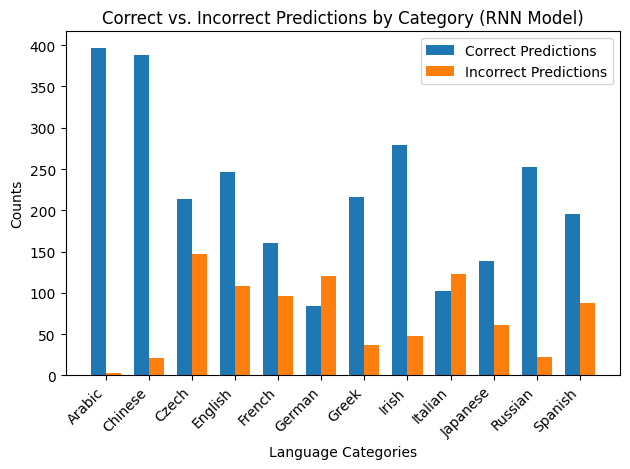

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation loop on the validation set for the RNN model
best_model_rnn.eval()
correct_counts = {category: 0 for category in all_categories}
incorrect_counts = {category: 0 for category in all_categories}

with torch.no_grad():
    for names, categories in val_dataloader:
        outputs = best_model_rnn(names.squeeze(2))
        _, predicted = torch.max(outputs, 1)

        for i in range(len(names)):
            true_category = all_categories[categories[i].item()]
            predicted_category = all_categories[predicted[i].item()]

            if true_category == predicted_category:
                correct_counts[true_category] += 1
            else:
                incorrect_counts[true_category] += 1

categories = list(all_categories)
correct_values = [correct_counts[category] for category in categories]
incorrect_values = [incorrect_counts[category] for category in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, correct_values, width, label='Correct Predictions')
rects2 = ax.bar(x + width/2, incorrect_values, width, label='Incorrect Predictions')

ax.set_xlabel('Language Categories')
ax.set_ylabel('Counts')
ax.set_title('Correct vs. Incorrect Predictions by Category (RNN Model)')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


##### Assessing correct and incorrect predictions for each language category in the validation set for LSTM

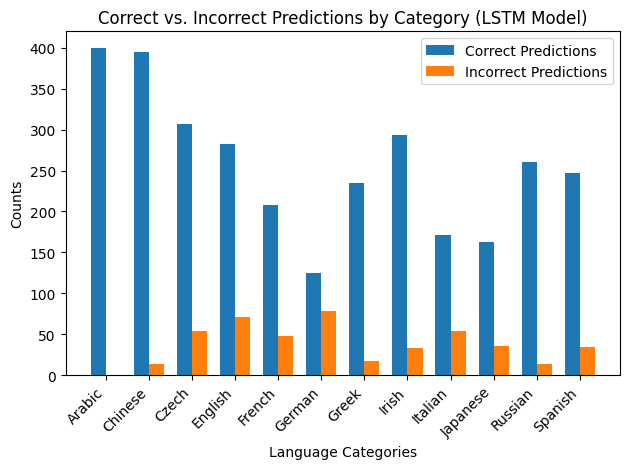

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation loop on the validation set for the RNN model
best_model_lstm.eval()
correct_counts = {category: 0 for category in all_categories}
incorrect_counts = {category: 0 for category in all_categories}

with torch.no_grad():
    for names, categories in val_dataloader:
        outputs = best_model_lstm(names.squeeze(2))
        _, predicted = torch.max(outputs, 1)

        for i in range(len(names)):
            true_category = all_categories[categories[i].item()]
            predicted_category = all_categories[predicted[i].item()]

            if true_category == predicted_category:
                correct_counts[true_category] += 1
            else:
                incorrect_counts[true_category] += 1

categories = list(all_categories)
correct_values = [correct_counts[category] for category in categories]
incorrect_values = [incorrect_counts[category] for category in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, correct_values, width, label='Correct Predictions')
rects2 = ax.bar(x + width/2, incorrect_values, width, label='Incorrect Predictions')

ax.set_xlabel('Language Categories')
ax.set_ylabel('Counts')
ax.set_title('Correct vs. Incorrect Predictions by Category (LSTM Model)')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

##### In conclusion, the above code uses RNN and LSTM models to classify the language of the given name. In the context of language classification, where the goal is to predict the language of a given name correctly, accuracy provides a clear measure of how well the model is performing in terms of making correct predictions. As it can be observed from the code, the accuracy is observed to be higher on the LSTM model which just used 31 epochs to get the best model with a loss of 0.5 and with an accuracy of 88%. Whereas, the RNN model took 36 epochs to get the best model and also the loss is higher than the LSTM model here which is 0.88 with the accuracy of 81%. This depicts that LSTM is the best model of choice for the language classification.